In [ ]:
import pandas as pd
import numpy as np
import csv
import datetime
from datetime import date, time, datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import gspread
import re

import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)


from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
import itertools
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import r2_score


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

from xgboost import XGBClassifier
from xgboost import XGBRegressor

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


In [ ]:
def getFeatures(df):
    num_features = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_features = df.select_dtypes(include=[np.object]).columns.tolist()
    return num_features,cat_features

def equalLists(array1, array2):
  an_array = np.array(array1)
  another_array = np.array(array2)    
  comparison = an_array == another_array
  equal_arrays = comparison.all()    
  return equal_arrays

def feature_engineering(df, cat_cols):
  """
  This function is used for feature engineering
  :param df: the pandas dataframe with train/test data
  :param cat_cols: list of categorical columns
  :return: dataframe with new features
  """
  # this will create all 2-combinations of values
  # in this list
  # for example:
  # list(itertools.combinations([1,2,3], 2)) will return
  # [(1, 2), (1, 3), (2, 3)]
  combi = list(itertools.combinations(cat_cols, 2))
  for c1, c2 in combi:
    df.loc[
    :,
    c1 + "_" + c2
    ] = df[c1].astype(str) + "_" + df[c2].astype(str)
  return df

def comparing_train_and_test_feature(df,df_test,col):
    fig = plt.figure(figsize=(16,10))
    ax0 = fig.add_subplot(1,2,1)
    ax1 = fig.add_subplot(1,2,2)
    df[col].plot(kind='kde',ax=ax0)
    df_test[col].plot(kind='kde',ax=ax1)
    ax0.set_xlabel(col)
    ax1.set_xlabel(col)
    ax0.set_title("Density plot of " + str(col) + " of training set")
    ax1.set_title("Density plot of " + str(col) + " of testing set")
    plt.show()

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values


In [ ]:
# custom function for easy and efficient analysis of numerical univariate

def UVA_numeric(data, var_group):
  ''' 
  Univariate_Analysis_numeric
  takes a group of variables (INTEGER and FLOAT) and plot/print all the descriptives and properties along with KDE.

  Runs a loop: calculate all the descriptives of i(th) variable and plot/print it
  '''

  size = len(var_group)
  plt.figure(figsize = (7*size,3), dpi = 100)
  
  #looping for each variable
  for j,i in enumerate(var_group):
    
    # calculating descriptives of variable
    mini = data[i].min()
    maxi = data[i].max()
    ran = data[i].max()-data[i].min()
    mean = data[i].mean()
    median = data[i].median()
    st_dev = data[i].std()
    skew = data[i].skew()
    kurt = data[i].kurtosis()

    # calculating points of standard deviation
    points = mean-st_dev, mean+st_dev

    #Plotting the variable with every information
    plt.subplot(1,size,j+1)
    sns.kdeplot(data[i], shade=True)
    sns.lineplot(points, [0,0], color = 'black', label = "std_dev")
    sns.scatterplot([mini,maxi], [0,0], color = 'orange', label = "min/max")
    sns.scatterplot([mean], [0], color = 'red', label = "mean")
    sns.scatterplot([median], [0], color = 'blue', label = "median")
    plt.xlabel('{}'.format(i), fontsize = 20)
    plt.ylabel('density')
    plt.title('std_dev = {}; kurtosis = {};\nskew = {}; range = {}\nmean = {}; median = {}'.format((round(points[0],2),round(points[1],2)),
                                                                                                   round(kurt,2),
                                                                                                   round(skew,2),
                                                                                                   (round(mini,2),round(maxi,2),round(ran,2)),
                                                                                                   round(mean,2),

                                                                                                   round(median,2)))
def UVA_category(data, var_group):

  '''
  Univariate_Analysis_categorical
  takes a group of variables (category) and plot/print all the value_counts and barplot.
  '''
  # setting figure_size
  size = len(var_group)
  plt.figure(figsize = (7*size,5), dpi = 100)

  # for every variable
  for j,i in enumerate(var_group):
    norm_count = data[i].value_counts(normalize = True)
    n_uni = data[i].nunique()

  #Plotting the variable with every information
    plt.subplot(1,size,j+1)
    sns.barplot(norm_count, norm_count.index , order = norm_count.index)
    plt.xlabel('fraction/percent', fontsize = 20)
    plt.ylabel('{}'.format(i), fontsize = 20)
    plt.title('n_uniques = {} \n value counts \n {};'.format(n_uni,norm_count))

# custom function for easy outlier analysis

def UVA_outlier(data, var_group, include_outlier = True):
  '''
  Univariate_Analysis_outlier:
  takes a group of variables (INTEGER and FLOAT) and plot/print boplot and descriptives\n
  Runs a loop: calculate all the descriptives of i(th) variable and plot/print it \n\n

  data : dataframe from which to plot from\n
  var_group : {list} type Group of Continuous variables\n
  include_outlier : {bool} whether to include outliers or not, default = True\n
  '''

  size = len(var_group)
  plt.figure(figsize = (7*size,4), dpi = 100)
  
  #looping for each variable
  for j,i in enumerate(var_group):
    
    # calculating descriptives of variable
    quant25 = data[i].quantile(0.25)
    quant75 = data[i].quantile(0.75)
    IQR = quant75 - quant25
    med = data[i].median()
    whis_low = med-(1.5*IQR)
    whis_high = med+(1.5*IQR)

    # Calculating Number of Outliers
    outlier_high = len(data[i][data[i]>whis_high])
    outlier_low = len(data[i][data[i]<whis_low])

    if include_outlier == True:
      print(include_outlier)
      #Plotting the variable with every information
      plt.subplot(1,size,j+1)
      sns.boxplot(data[i], orient="v")
      plt.ylabel('{}'.format(i))
      plt.title('With Outliers\nIQR = {}; Median = {} \n 2nd,3rd  quartile = {};\n Outlier (low/high) = {} \n'.format(
                                                                                                   round(IQR,2),
                                                                                                   round(med,2),
                                                                                                   (round(quant25,2),round(quant75,2)),
                                                                                                   (outlier_low,outlier_high)
                                                                                                   ))
      
    else:
      # replacing outliers with max/min whisker
      data2 = data[var_group][:]
      data2[i][data2[i]>whis_high] = whis_high+1
      data2[i][data2[i]<whis_low] = whis_low-1
      
      # plotting without outliers
      plt.subplot(1,size,j+1)
      sns.boxplot(data2[i], orient="v")
      plt.ylabel('{}'.format(i))
      plt.title('Without Outliers\nIQR = {}; Median = {} \n 2nd,3rd  quartile = {};\n Outlier (low/high) = {} \n'.format(
                                                                                                   round(IQR,2),
                                                                                                   round(med,2),
                                                                                                   (round(quant25,2),round(quant75,2)),
                                                                                                   (outlier_low,outlier_high)
                                                                                                   ))

def TwoSampZ(X1, X2, sigma1, sigma2, N1, N2):
  '''
  takes mean, standard deviation, and number of observations and returns p-value calculated for 2-sampled Z-Test
  '''
  from numpy import sqrt, abs, round
  from scipy.stats import norm
  ovr_sigma = sqrt(sigma1**2/N1 + sigma2**2/N2)
  z = (X1 - X2)/ovr_sigma
  pval = 2*(1 - norm.cdf(abs(z)))
  return pval

def TwoSampT(X1, X2, sd1, sd2, n1, n2):
  '''
  takes mean, standard deviation, and number of observations and returns p-value calculated for 2-sample T-Test
  '''
  from numpy import sqrt, abs, round
  from scipy.stats import t as t_dist
  ovr_sd = sqrt(sd1**2/n1 + sd2**2/n2)
  t = (X1 - X2)/ovr_sd
  df = n1+n2-2
  pval = 2*(1 - t_dist.cdf(abs(t),df))
  return pval

def Bivariate_cont_cat(data, cont, cat, category):
  #creating 2 samples
  x1 = data[cont][data[cat]==category][:]
  x2 = data[cont][~(data[cat]==category)][:]
  
  #calculating descriptives
  n1, n2 = x1.shape[0], x2.shape[0]
  m1, m2 = x1.mean(), x2.mean()
  std1, std2 = x1.std(), x2.mean()
  
  #calculating p-values
  t_p_val = TwoSampT(m1, m2, std1, std2, n1, n2)
  z_p_val = TwoSampZ(m1, m2, std1, std2, n1, n2)

  #table
  table = pd.pivot_table(data=data, values=cont, columns=cat, aggfunc = np.mean)

  #plotting
  plt.figure(figsize = (15,6), dpi=140)
  
  #barplot
  plt.subplot(1,2,1)
  sns.barplot([str(category),'not {}'.format(category)], [m1, m2])
  plt.ylabel('mean {}'.format(cont))
  plt.xlabel(cat)
  plt.title('t-test p-value = {} \n z-test p-value = {}\n {}'.format(t_p_val,
                                                                z_p_val,
                                                                table))

  # boxplot
  plt.subplot(1,2,2)
  sns.boxplot(x=cat, y=cont, data=data)
  plt.title('categorical boxplot')

def BVA_categorical_plot(data, tar, cat):
  '''
  take data and two categorical variables,
  calculates the chi2 significance between the two variables 
  and prints the result with countplot & CrossTab
  '''
  #isolating the variables
  data = data[[cat,tar]][:]

  #forming a crosstab
  table = pd.crosstab(data[tar],data[cat],)
  f_obs = np.array([table.iloc[0][:].values,
                    table.iloc[1][:].values])

  #performing chi2 test
  from scipy.stats import chi2_contingency
  chi, p, dof, expected = chi2_contingency(f_obs)
  
  #checking whether results are significant
  if p<0.05:
    sig = True
  else:
    sig = False

  #plotting grouped plot
  sns.countplot(x=cat, hue=tar, data=data)
  plt.title("p-value = {}\n difference significant? = {}\n".format(round(p,8),sig))

  #plotting percent stacked bar plot
  #sns.catplot(ax, kind='stacked')
  ax1 = data.groupby(cat)[tar].value_counts(normalize=True).unstack()
  ax1.plot(kind='bar', stacked='True',title=str(ax1))
  int_level = data[cat].value_counts()

In [ ]:
trainDataRaw = pd.read_csv("/content/drive/MyDrive/AI ML Projects/TMC/train.csv")
testDataRaw = pd.read_csv("/content/drive/MyDrive/AI ML Projects/TMC/test.csv")

In [ ]:
testDataRawcopy = testDataRaw.copy()
trainDataRawcopy = trainDataRaw.copy()
testDataRawcopy["Price"] = -1

In [ ]:
#Feature Engineering - Convert "Mileage" and "Engine volume" to numerical , Change "Prod. year" to age of vehicle, Add RARE - Levy, Manufacturer, Model, Fuel type, Category, Engine volume, Color
#Other cleanup - Remove outliers on Price, Cylinders
num_features,cat_features = getFeatures(trainDataRaw)
#for col in cat_features:
#  print("\n cat: ", col, "\n", trainDataRaw[col].value_counts())
#  print()

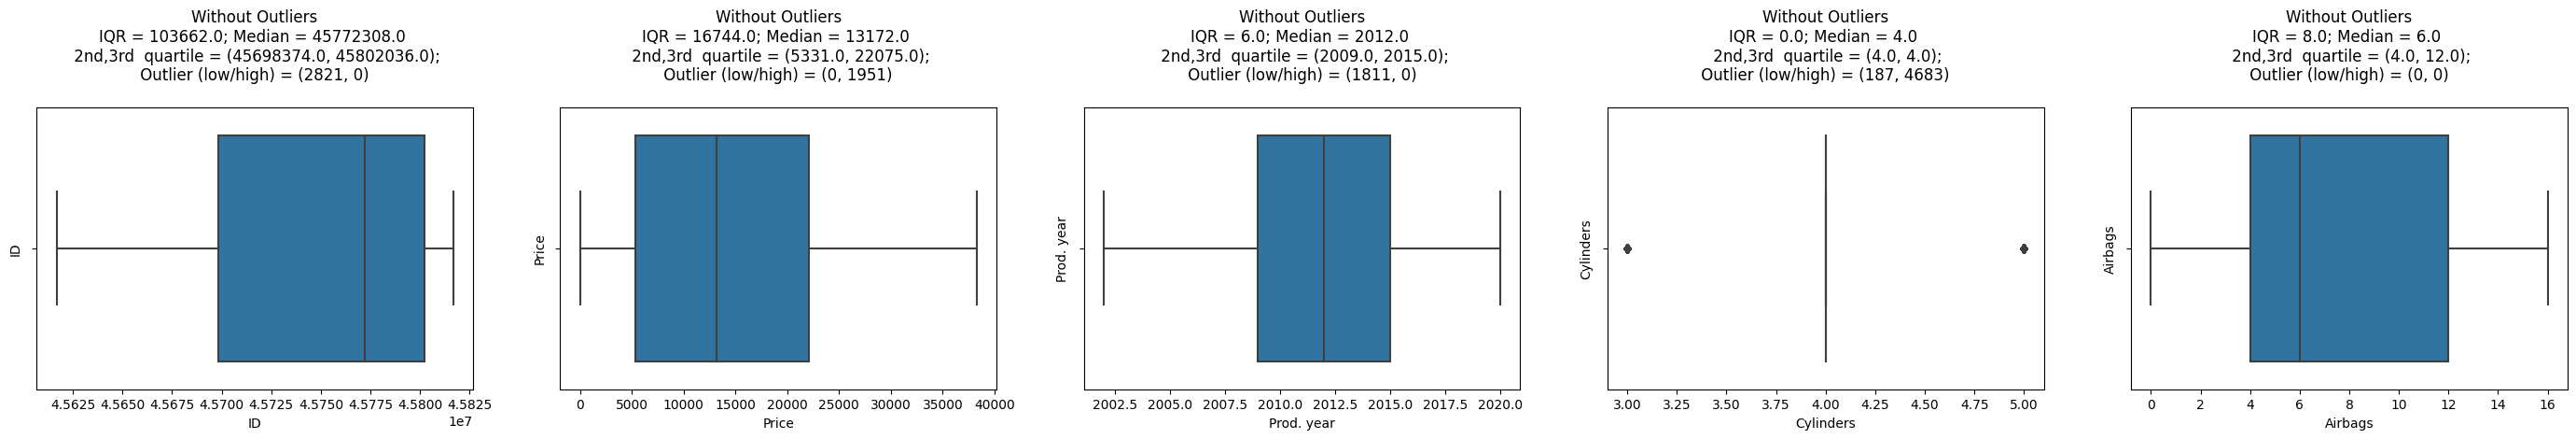

In [ ]:
UVA_outlier(trainDataRaw, num_features, include_outlier=False)

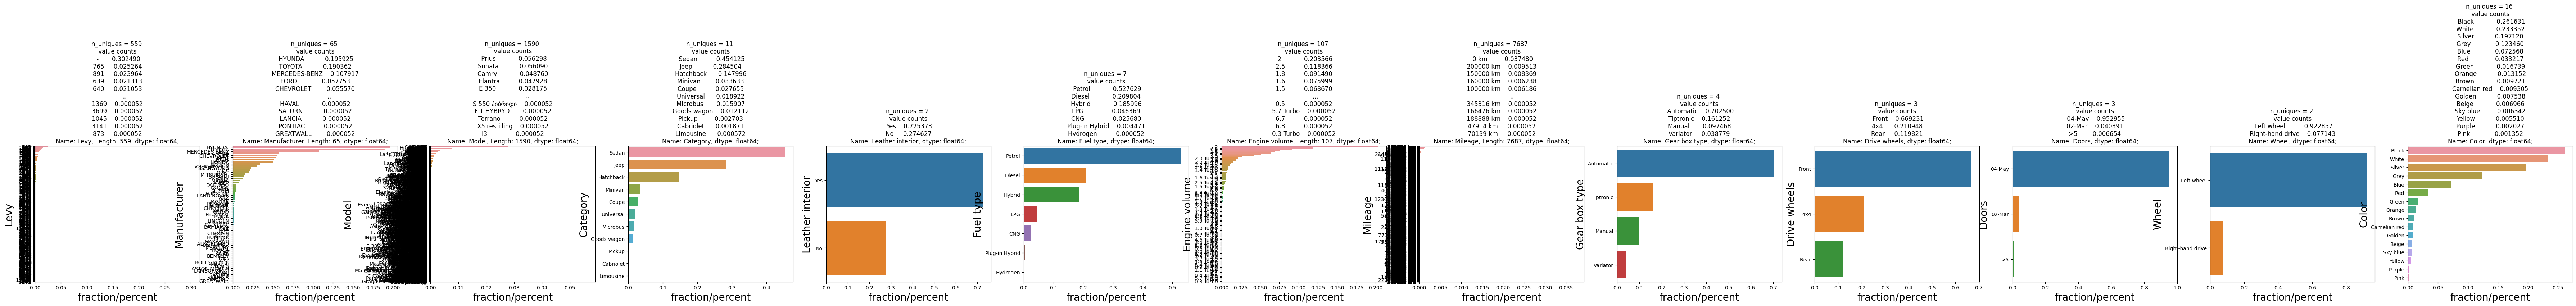

In [ ]:
UVA_category(trainDataRaw, cat_features)

In [ ]:
trainDataRaw["Model"].value_counts(normalize=True)

Prius            0.056298
Sonata           0.056090
Camry            0.048760
Elantra          0.047928
E 350            0.028175
                   ...   
S 550 ჰიბრიდი    0.000052
FIT HYBRYD       0.000052
Terrano          0.000052
X5 restilling    0.000052
i3               0.000052
Name: Model, Length: 1590, dtype: float64

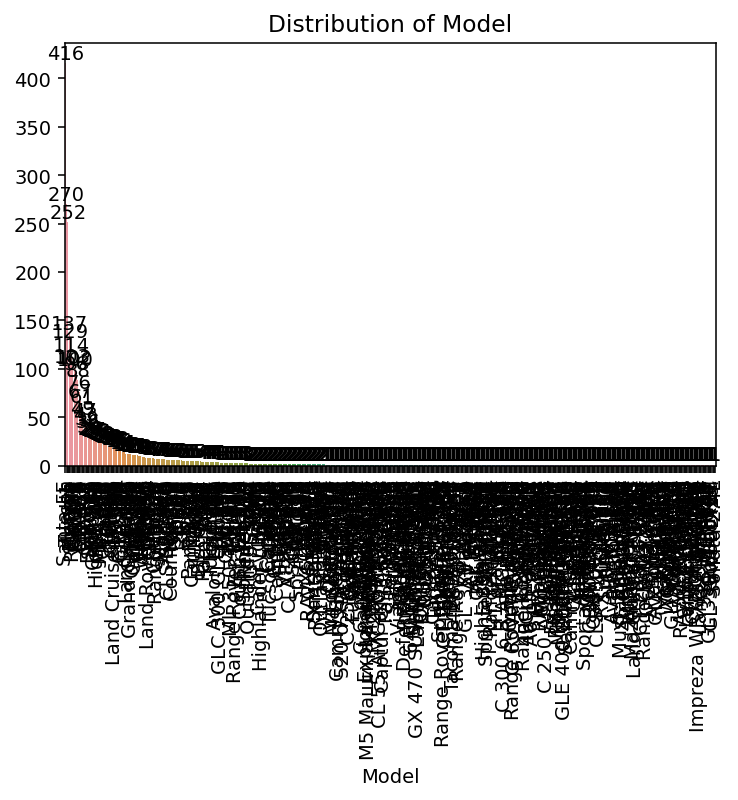

In [ ]:
plt.figure(dpi = 140)
ax = sns.barplot(x=trainDataRaw[trainDataRaw['Price'] > trainDataRaw["Price"].quantile([.8]).values[0]]['Model'].value_counts().index, y=trainDataRaw[trainDataRaw['Price'] > trainDataRaw["Price"].quantile([.8]).values[0]]['Model'].value_counts().values, orient = 'v')
plt.title('Distribution of Model')
plt.xlabel('Model')
for p in ax.patches:
        ax.annotate('{:1.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black')
plt.xticks(rotation = 90)        
plt.show()

In [ ]:
c = trainDataRaw[num_features].corr().abs()
s = c.unstack()
so = s.sort_values(kind='quicksort', ascending = False)
so = pd.DataFrame(so, columns = ['Pearson correlation'])
so[so['Pearson correlation'] < 1].head(20)

Pearson correlation
Airbags    Prod. year             0.236969
Prod. year Airbags                0.236969
Airbags    Cylinders              0.176868
Cylinders  Airbags                0.176868
           Prod. year             0.096797
Prod. year Cylinders              0.096797
ID         Prod. year             0.071352
Prod. year ID                     0.071352
Cylinders  ID                     0.039319
ID         Cylinders              0.039319
           Airbags                0.020527
Airbags    ID                     0.020527
Prod. year Price                  0.012982
Price      Prod. year             0.012982
           Airbags                0.012824
Airbags    Price                  0.012824
Price      Cylinders              0.007518
Cylinders  Price                  0.007518
Price      ID                     0.000844
ID         Price                  0.000844

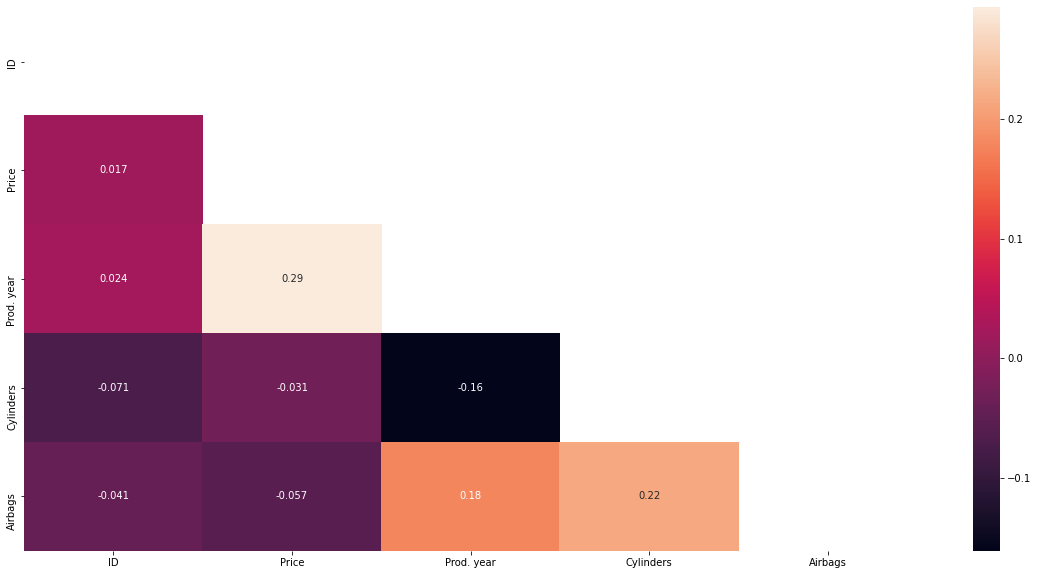

In [ ]:
#'pearson','kendall','spearman'
corrMatrix=trainDataRaw[num_features].corr(method='spearman')
#print(corrMatrix)

plt.figure(figsize=(20,10))
mask = np.zeros_like(corrMatrix,dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrMatrix,mask=mask,annot=True)
plt.show()

<Figure size 840x560 with 0 Axes>

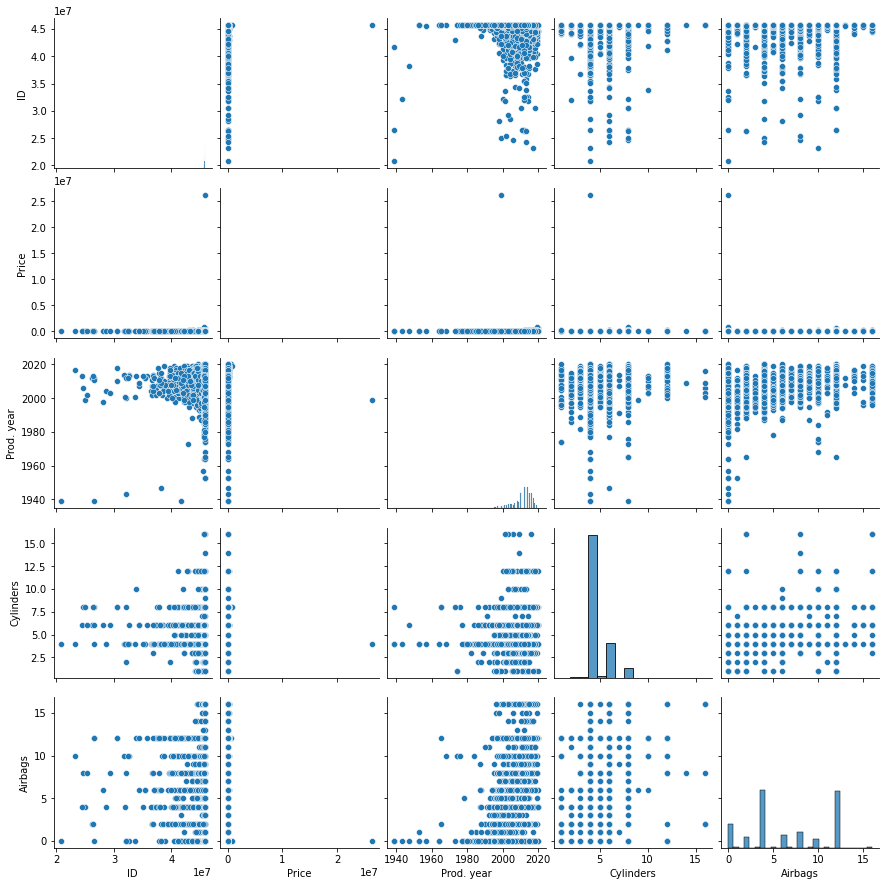

In [ ]:
# scatter plot for transactional variables
plt.figure(dpi=140)
sns.pairplot(trainDataRaw[num_features])

In [ ]:
print(num_features, cat_features)

['ID', 'Price', 'Prod. year', 'Cylinders', 'Airbags'] ['Levy', 'Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type', 'Engine volume', 'Mileage', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color']


In [ ]:
for col in ['Prod. year', 'Cylinders', 'Airbags']:
  comparing_train_and_test_feature(trainDataRawcopy, testDataRawcopy, col )

In [ ]:
## Box plot of numerical features
fig = plt.figure(figsize=(30,20))
for i in range(len(num_features)):
    fig.add_subplot(4,5,i+1)
    sns.boxplot(y = trainDataRaw[num_features].iloc[:,i])
plt.tight_layout()
plt.show()

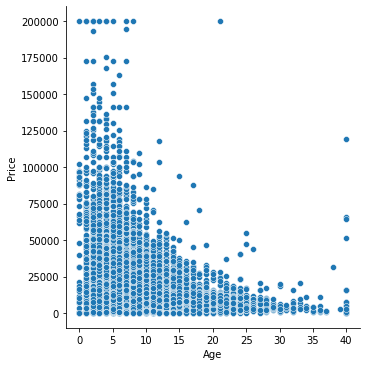

In [ ]:
#trainDataRaw["Category"].hist()
#tips = sns.load_dataset(trainDataRaw)
#sns.catplot(x=trainDataRaw["Category"], y=trainDataRaw.groupby("Category")["Price"].mean())
#sns.countplot(x ='Cylinders', data = testDataRawcopy)#,, y ='Price'
            #palette ='plasma', estimator = np.std)
sns.relplot(x="Age", y="Price", data=trainDataRawcopy);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


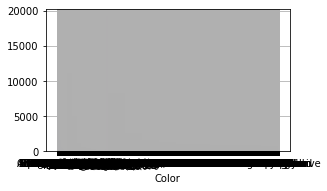

In [ ]:
fig = plt.figure(figsize=(20,10))
for col in cat_features:
    fig.add_subplot(4,5,len(cat_features)+1)
    trainDataRaw[col].hist()
    plt.xlabel(col)de
plt.tight_layout()
plt.show()

In [ ]:
trainDataRawcopy.quantile([0, .1, .25, .5, .75, 0.99, 1], axis = 0)

,ID,Price,Prod. year,Cylinders,Airbags
0.00,20746880.00,1.0,1939.0,1.0,0.0
0.10,45416463.40,627.0,2003.0,4.0,0.0
0.25,45698374.00,5331.0,2009.0,4.0,4.0
0.50,45772308.00,13172.0,2012.0,4.0,6.0
0.75,45802036.00,22075.0,2015.0,4.0,12.0
0.99,45816132.64,84675.0,2019.0,8.0,12.0
1.00,45816654.00,200000.0,2020.0,16.0,16.0


In [ ]:
milArr = trainDataRawcopy["Mileage"].unique()
print(milArr)
print(list(map(lambda x: int(x.split()[0]) ,milArr) ) )

['186005 km' '192000 km' '200000 km' ... '140607 km' '307325 km'
 '186923 km']
[186005, 192000, 200000, 168966, 91901, 160931, 258909, 216118, 398069, 128500, 184467, 0, 350000, 138038, 76000, 74146, 121840, 54317, 295059, 364523, 112645, 187000, 39709, 230000, 210000, 169000, 158787, 420550, 180000, 175056, 287274, 250000, 162000, 10200, 158000, 103490, 382746, 203200, 61057, 11200, 141000, 160259, 239342, 128000, 100734, 141500, 147000, 87768, 264014, 132542, 1600, 87000, 260000, 5323, 87112, 204318, 22000, 83000, 170000, 312118, 130000, 200279, 719847, 154672, 110969, 225510, 148105, 255456, 111643, 84506, 288000, 75000, 94362, 175000, 263190, 193614, 264877, 27656, 16000, 195053, 121362, 69191, 40772, 172000, 433811, 148213, 103246, 105394, 160000, 333333, 214000, 123346, 80827, 64464, 91760, 275240, 300000, 318400, 91200, 137802, 151586, 107000, 210408, 100567, 86000, 122740, 144000, 150000, 100000, 178000, 85704, 58962, 90000, 50000, 318358, 71454, 346470, 59515, 115312, 111111, 

In [ ]:
trainDataRawcopy.loc[trainDataRawcopy["Price"] >= 200000, "Price"] = 200000
trainDataRawcopy.loc[trainDataRawcopy["Cylinders"] >= 7, "Cylinders"] = 8
trainDataRawcopy.loc[(trainDataRawcopy["Cylinders"] >= 5) & (trainDataRawcopy["Cylinders"] <=6) , "Cylinders"] = 6
trainDataRawcopy.loc[trainDataRawcopy["Cylinders"] <= 4 , "Cylinders"] = 4
trainDataRawcopy.loc[trainDataRawcopy["Prod. year"] <= 1980 , "Prod. year"] = 1980
trainDataRawcopy["Age"] = trainDataRawcopy["Prod. year"].apply(lambda x: (2020 - x))
trainDataRawcopy["Mileage"] = trainDataRawcopy["Mileage"].apply(lambda x: int(x.split()[0]))
trainDataRawcopy["Mileage"] = pd.to_numeric(trainDataRawcopy["Mileage"])

testDataRawcopy.loc[testDataRawcopy["Cylinders"] >= 7, "Cylinders"] = 8
testDataRawcopy.loc[(testDataRawcopy["Cylinders"] >= 5) & (testDataRawcopy["Cylinders"] <=6) , "Cylinders"] = 6
testDataRawcopy.loc[testDataRawcopy["Cylinders"] <= 4 , "Cylinders"] = 4
testDataRawcopy.loc[testDataRawcopy["Prod. year"] <= 1980 , "Prod. year"] = 1980
testDataRawcopy["Age"] = testDataRawcopy["Prod. year"].apply(lambda x: (2020 - x))
testDataRawcopy["Mileage"] = testDataRawcopy["Mileage"].apply(lambda x: int(x.split()[0]))
testDataRawcopy["Mileage"] = pd.to_numeric(testDataRawcopy["Mileage"])


In [ ]:
num_attribs,cat_attribs = getFeatures(trainDataRawcopy)
trainDataRawcopy[cat_attribs] = trainDataRawcopy[cat_attribs].fillna(value="unknown")
trainDataRawcopy[num_attribs] = trainDataRawcopy[num_attribs].fillna(trainDataRawcopy[num_attribs].median())

trainDataRawcopy.loc[ 
       trainDataRawcopy["Levy"].value_counts()[trainDataRawcopy["Levy"]].values < 100,
       "Levy"
       ] = "RARE"

trainDataRawcopy.loc[ 
       trainDataRawcopy["Manufacturer"].value_counts()[trainDataRawcopy["Manufacturer"]].values < 100,
       "Manufacturer"
       ] = "RARE"

trainDataRawcopy.loc[ 
       trainDataRawcopy["Model"].value_counts()[trainDataRawcopy["Model"]].values < 100,
       "Model"
       ] = "RARE"

trainDataRawcopy.loc[ 
       trainDataRawcopy["Fuel type"].value_counts()[trainDataRawcopy["Fuel type"]].values < 100,
       "Fuel type"
       ] = "RARE"

trainDataRawcopy.loc[ 
       trainDataRawcopy["Category"].value_counts()[trainDataRawcopy["Category"]].values < 100,
       "Category"
       ] = "RARE"

trainDataRawcopy.loc[ 
       trainDataRawcopy["Engine volume"].value_counts()[trainDataRawcopy["Engine volume"]].values < 100,
       "Engine volume"
       ] = "RARE"

trainDataRawcopy.loc[ 
       trainDataRawcopy["Color"].value_counts()[trainDataRawcopy["Color"]].values < 100,
       "Color"
       ] = "RARE"

testDataRawcopy[cat_attribs] = testDataRawcopy[cat_attribs].fillna(value="unknown")
testDataRawcopy[num_attribs] = testDataRawcopy[num_attribs].fillna(testDataRawcopy[num_attribs].median())

testDataRawcopy.loc[ 
       testDataRawcopy["Levy"].value_counts()[testDataRawcopy["Levy"]].values < 100,
       "Levy"
       ] = "RARE"

testDataRawcopy.loc[ 
       testDataRawcopy["Manufacturer"].value_counts()[testDataRawcopy["Manufacturer"]].values < 100,
       "Manufacturer"
       ] = "RARE"

testDataRawcopy.loc[ 
       testDataRawcopy["Model"].value_counts()[testDataRawcopy["Model"]].values < 100,
       "Model"
       ] = "RARE"

testDataRawcopy.loc[ 
       testDataRawcopy["Fuel type"].value_counts()[testDataRawcopy["Fuel type"]].values < 100,
       "Fuel type"
       ] = "RARE"

testDataRawcopy.loc[ 
       testDataRawcopy["Category"].value_counts()[testDataRawcopy["Category"]].values < 100,
       "Category"
       ] = "RARE"

testDataRawcopy.loc[ 
       testDataRawcopy["Engine volume"].value_counts()[testDataRawcopy["Engine volume"]].values < 100,
       "Engine volume"
       ] = "RARE"

testDataRawcopy.loc[ 
       testDataRawcopy["Color"].value_counts()[testDataRawcopy["Color"]].values < 100,
       "Color"
       ] = "RARE"



In [ ]:
num_attribs,cat_attribs = getFeatures(trainDataRawcopy)
print(num_attribs, cat_attribs)

['ID', 'Price', 'Prod. year', 'Mileage', 'Cylinders', 'Airbags', 'Age'] ['Levy', 'Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type', 'Engine volume', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color']


In [ ]:
trainDataRawcopy = feature_engineering(trainDataRawcopy,cat_attribs)
testDataRawcopy = feature_engineering(testDataRawcopy ,cat_attribs)

num_attribs,cat_attribs = getFeatures(trainDataRawcopy)

final_num_columns = [i for i in num_attribs if i not in ['ID', 'Price'] ]

power = PowerTransformer(method='yeo-johnson', standardize=True)
scaler = StandardScaler()

trainDataRawcopy[final_num_columns] = scaler.fit_transform(trainDataRawcopy[final_num_columns])
#trainDataRawcopy[final_num_columns] = power.fit_transform(trainDataRawcopy[final_num_columns])

testDataRawcopy[final_num_columns] = scaler.fit_transform(testDataRawcopy[final_num_columns])
#testDataRawcopy[final_num_columns] = power.fit_transform(testDataRawcopy[final_num_columns])


In [ ]:
maxPrice = max(trainDataRawcopy["Price"])

trainDataRawcopy["Price"] = trainDataRawcopy["Price"] / maxPrice
testDataRawcopy["Price"] = testDataRawcopy["Price"] / maxPrice

In [ ]:
trainDataRawcopy.shape


(19237, 85)

In [ ]:
trainDataRawcopy2 = trainDataRawcopy.copy()
testDataRawcopy2 = testDataRawcopy.copy()

num_attribs,cat_attribs = getFeatures(trainDataRawcopy2.drop(['ID', 'Price'], axis = 1))
cat_drop_list = []
final_cat_columns = [i for i in cat_attribs if i not in cat_drop_list]

combined_train_testRaw2 = pd.concat([trainDataRawcopy2,testDataRawcopy2])

label_encoder = preprocessing.LabelEncoder()
train_trans =  np.empty((trainDataRawcopy2.shape[0]))
test_trans = np.empty((testDataRawcopy2.shape[0]))
#train_trans = np.array(train_trans)
#test_trans = np.array(test_trans)
i = 0
for col in final_cat_columns:
  label_encoder.fit(combined_train_testRaw2[col])
  train_trans = np.column_stack((train_trans, label_encoder.transform(trainDataRawcopy2[col])))
  test_trans = np.column_stack((test_trans, label_encoder.transform(testDataRawcopy2[col])))
#print(train_trans.shape, test_trans.shape)
trainDataRawcopy2Encoded = pd.concat([trainDataRawcopy2, pd.DataFrame(train_trans)], axis=1).drop(cat_attribs, axis=1) 
testDataRawcopy2Encoded= pd.concat([testDataRawcopy2, pd.DataFrame(test_trans)], axis=1).drop(cat_attribs, axis=1)


'''ohe = OneHotEncoder(sparse=False, handle_unknown ='ignore') 
ohe.fit(combined_train_testRaw2[final_cat_columns])
transformed = ohe.transform(trainDataRawcopy2[final_cat_columns])
ohe_df = pd.DataFrame(transformed)
trainDataRawcopy2Encoded= pd.concat([trainDataRawcopy2, ohe_df], axis=1).drop(cat_attribs, axis=1)

#label_encoder = LabelBinarizer()
ohe = OneHotEncoder(sparse=False, handle_unknown ='ignore') 
ohe.fit(combined_train_testRaw2[final_cat_columns])
transformed = ohe.transform(testDataRawcopy2[final_cat_columns])
ohe_df = pd.DataFrame(transformed)
print(ohe_df)
testDataRawcopy2Encoded= pd.concat([testDataRawcopy2, ohe_df], axis=1).drop(cat_attribs, axis=1)'''

print(trainDataRawcopy2Encoded.shape, testDataRawcopy2Encoded.shape)

(19237, 86) (8245, 86)


In [ ]:
num_attribs,cat_attribs = getFeatures(trainDataRawcopy2Encoded.drop(['ID', 'Price'], axis = 1))
features = num_attribs + cat_attribs

x_train_1, y_train = trainDataRawcopy2Encoded.iloc[:15000][features], trainDataRawcopy2Encoded.iloc[:15000]["Price"]
x_test_1, y_test = trainDataRawcopy2Encoded.iloc[15000:][features], trainDataRawcopy2Encoded.iloc[15000:]["Price"]
x_final_1, y_final = testDataRawcopy2Encoded[features], testDataRawcopy2Encoded["Price"]

print(x_train_1.shape, x_test_1.shape, y_train.shape, y_test.shape, x_final_1.shape, y_final.shape)

(15000, 84) (4237, 84) (15000,) (4237,) (8245, 84) (8245,)


In [ ]:
y_train[np.isnan(y_train)] = 0
y_test[np.isnan(y_test)] = 0


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)


In [ ]:
XGBModel = XGBRegressor(n_estimators=500,max_depth=10,booster='gbtree',n_jobs=-1,learning_rate=0.05,reg_lambda=0.01,reg_alpha=0.3, colsample_bytree =  0.7, gamma = 0.0, min_child_weight = 7, objective = 'reg:squarederror', subsample = 0.7)

XGBModel.fit(x_train_1, y_train, 
        early_stopping_rounds=1000, eval_metric="rmse", eval_set=[(x_test_1, y_test)], verbose=100, 
        )

ypredXgb = XGBModel.predict(x_train_1)
print("Train Accuracy Score " , r2_score(y_train, ypredXgb) )

ypredTestypredXgb = XGBModel.predict(x_test_1)
print("Test Accuracy Score " , r2_score(y_test, ypredTestypredXgb) )

ypredFinalXgb = XGBModel.predict(x_final_1)

[0]	validation_0-rmse:0.403912
Will train until validation_0-rmse hasn't improved in 2000 rounds.
[100]	validation_0-rmse:0.048714
[200]	validation_0-rmse:0.046796
[300]	validation_0-rmse:0.046248
[400]	validation_0-rmse:0.046009
[499]	validation_0-rmse:0.045942
Train Accuracy Score  0.9420796688925229
Test Accuracy Score  0.7290356822330795


In [ ]:
import lightgbm as lgb 
lgbm_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'rmse'],
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 10,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 100000,
    "n_estimators": 1000
}

new_params = {
    'boosting_type': 'dart',
 'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 10,
 'n_estimators': 500,
 'num_leaves': 30,
 'objective': 'regression',
 'sub_feature': 0.8,
 'subsample': 0.7
}

gbm = lgb.LGBMRegressor(**lgbm_params)
gbm.fit(x_train_1, y_train,
        eval_set=[(x_test_1, y_test)],
        eval_metric='l1',
        early_stopping_rounds=1000, verbose=100)

ypredGbm = gbm.predict(x_train_1, num_iteration=gbm.best_iteration_)
print("Train Accuracy Score " , r2_score(y_train, ypredGbm) )

ypredTestGbm = gbm.predict(x_test_1, num_iteration=gbm.best_iteration_)
print("Test Accuracy Score " , r2_score(y_test, ypredTestGbm) )

'''gbm = lgb.LGBMRegressor(**new_params)
gbm.fit(x_train_1, y_train,
        eval_set=[(x_test_1, y_test)],
        eval_metric='l1',
        early_stopping_rounds=1000,verbose=100)

ypredGbm = gbm.predict(x_train_1, num_iteration=gbm.best_iteration_)
print("Train Accuracy Score with new params" , r2_score(y_train, ypredGbm) )

ypredTestGbm = gbm.predict(x_test_1, num_iteration=gbm.best_iteration_)
print("Test Accuracy Score with new params" , r2_score(y_test, ypredTestGbm) )'''

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 1000 rounds.
[100]	valid_0's l2: 0.00237302	valid_0's l1: 0.0259818	valid_0's rmse: 0.0487136
[200]	valid_0's l2: 0.00226535	valid_0's l1: 0.0247558	valid_0's rmse: 0.0475957
[300]	valid_0's l2: 0.00219852	valid_0's l1: 0.0241091	valid_0's rmse: 0.0468884
[400]	valid_0's l2: 0.00213311	valid_0's l1: 0.0235753	valid_0's rmse: 0.0461856
[500]	valid_0's l2: 0.00211742	valid_0's l1: 0.0233052	valid_0's rmse: 0.0460154
[600]	valid_0's l2: 0.00209841	valid_0's l1: 0.0231147	valid_0's rmse: 0.0458084
[700]	valid_0's l2: 0.00209758	valid_0's l1: 0.0230221	valid_0's rmse: 0.0457993
[800]	valid_0's l2: 0.00209135	valid_0's l1: 0.0228737	valid_0's rmse: 0.0457312
[900]	valid_0's l2: 0.00208182	valid_0's l1: 0.022751	valid_0's rmse: 0.045627
[1000]	valid_0's l2: 0.00207747	valid_0's l1: 0.0226733	valid_0's rmse: 0.0455793
[1100]	valid_0's l2: 0.00208303	valid_0's l1: 0.0226449	valid_0's rmse: 0.0456402
[1200]	valid_0's l2: 0.00207405	valid_0's l1:

'gbm = lgb.LGBMRegressor(**new_params)\ngbm.fit(x_train_1, y_train,\n        eval_set=[(x_test_1, y_test)],\n        eval_metric=\'l1\',\n        early_stopping_rounds=1000,verbose=100)\n\nypredGbm = gbm.predict(x_train_1, num_iteration=gbm.best_iteration_)\nprint("Train Accuracy Score with new params" , r2_score(y_train, ypredGbm) )\n\nypredTestGbm = gbm.predict(x_test_1, num_iteration=gbm.best_iteration_)\nprint("Test Accuracy Score with new params" , r2_score(y_test, ypredTestGbm) )'

In [ ]:
import sklearn.base as skb
class MixModel(skb.BaseEstimator,skb.RegressorMixin,skb.TransformerMixin):
    def __init__(self,algs):
        self.algs = algs
    def fit(self,X,y):
        self.algs_ = [skb.clone(x) for x in self.algs]
        for alg in self.algs_:
            alg.fit(X,y)
        return self
    def predict(self,X):
        predictions = np.column_stack([
            stacked_model.predict(X) for stacked_model in self.algs_
        ])
        return np.mean(predictions,axis=1)

In [ ]:
mixed_model = MixModel(algs = [XGBModel, gbm])
combined_x_train = pd.concat([x_train, x_test])
combined_y_train = pd.concat([y_train, y_test])
mixed_model.fit(combined_x_train, combined_y_train)
y_train_pred = mixed_model.predict(x_train)
y_test_pred = mixed_model.predict(x_test)
y_test_final_mixed = mixed_model.predict(x_final)
print(r2_score(y_train,y_train_pred))
print(r2_score(y_test,y_test_pred))

0.8666824907382081
0.8589941106077792


In [ ]:
num_attribs,cat_attribs = getFeatures(trainDataRawcopy.drop(['ID', 'Price'], axis = 1))
cat_drop_list = []
final_cat_columns = [i for i in cat_attribs if i not in cat_drop_list]
print(trainDataRawcopy.shape)
combined_train_testRaw = pd.concat([trainDataRawcopy,testDataRawcopy])
#converting data to list format to match the network structure
def preproc(X_train, X_val, X_test, cat_attribs ):#, ):

    input_list_train = []
    input_list_val = []
    input_list_test = []
    
    print("number of cat columns: ", len(cat_attribs))
    #the cols to be embedded: rescaling to range [0, # values)
    for c in cat_attribs:
        raw_vals = np.unique(X_train[c] + X_val[c] + X_test[c] )
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        input_list_train.append(X_train[c].map(val_map).fillna(0).values)
        input_list_val.append(X_val[c].map(val_map).fillna(0).values)
        input_list_test.append(X_test[c].map(val_map).fillna(0).values)

    #the rest of the columns
    other_cols = [c for c in X_train.columns if (not c in cat_attribs)]
    print("number of non-cat columns: ", len(other_cols))
    #for notc in other_cols:
    #  input_list_train.append(X_train[notc].values)
    #  input_list_val.append(X_val[notc].values)
    for o in other_cols: 
      input_list_train.append(X_train[o].values)
      input_list_val.append(X_val[o].values)
      input_list_test.append(X_test[o].values)
    
    return input_list_train, input_list_val, input_list_test

for categorical_var in trainDataRawcopy[final_cat_columns]:
    cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'  
    no_of_unique_cat  = combined_train_testRaw[categorical_var].nunique()
    #print(categorical_var, equalLists(trainDataRawPro2[categorical_var].unique(),testDataRawPro2[categorical_var].unique()))
    embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50 ))
  
#    print('Categorica Variable:', categorical_var,
#        'Unique Categories:', no_of_unique_cat,
#        'Embedding Size:', embedding_size)

(19237, 85)


In [ ]:
testDataRawcopy.shape

(8245, 85)

In [ ]:
features = num_attribs + final_cat_columns

x_train, y_train = trainDataRawcopy.iloc[:15000][features], trainDataRawcopy.iloc[:15000]["Price"]
x_test, y_test = trainDataRawcopy.iloc[15000:][features], trainDataRawcopy.iloc[15000:]["Price"]
x_final, y_final = testDataRawcopy[features], testDataRawcopy["Price"]

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, x_final.shape, y_final.shape)

(15000, 83) (4237, 83) (15000,) (4237,) (8245, 83) (8245,)


In [ ]:
y_train[np.isnan(y_train)] = 0
y_test[np.isnan(y_test)] = 0


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)


In [ ]:
from keras.layers import Input, Dense, Activation, Reshape
from keras.models import Sequential,Model
from keras.models import Model as KerasModel
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Concatenate, Dropout
from keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

def combined_entity_embedding_model():
  input_models=[]
  output_embeddings=[]
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  for categorical_var in final_cat_columns:
      
      #Name of the categorical variable that will be used in the Keras Embedding layer
      cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'
    
      # Define the embedding_size
      #print(categorical_var)
      #total_set = x_train[categorical_var].unique() + x_test[categorical_var].unique() + x_final[categorical_var].unique()
      res = []
      [res.append(x) for x in x_train[categorical_var].unique() if x not in res]
      [res.append(x) for x in x_test[categorical_var].unique() if x not in res]
      [res.append(x) for x in x_final[categorical_var].unique() if x not in res]

      no_of_unique_cat  = len(res)#combined_train_testRawPro2[categorical_var].nunique() #x_train[categorical_var].nunique() + x_test[categorical_var].nunique() + x_final[categorical_var].nunique()
      #print(x_train[categorical_var].nunique())
      #print(no_of_unique_cat)
      embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50 ))
    
      #One Embedding Layer for each categorical variable
      input_model = Input(shape=(1,))
      output_model = Embedding(no_of_unique_cat + 1, embedding_size, name=cat_emb_name)(input_model)
      output_model = Reshape(target_shape=(embedding_size,))(output_model)    
    
      #Appending all the categorical inputs
      input_models.append(input_model)
    
      #Appending all the embeddings
      output_embeddings.append(output_model)
    
  print("Done with categorical")
  #Other non-categorical data columns (numerical). 
  #I define single another network for the other columns and add them to our models list.
  input_numeric = []#Input(shape=(len(num_attribs),))
  print("Expected number of num attribs: ", num_attribs)
  for num_col in num_attribs:
     input_model = Input(shape=(1,)) 
     input_models.append(input_model)
     embedding_numeric = Dense(128)(input_model) 
     output_embeddings.append(embedding_numeric)
     #input_numeric.append(input_model)
  print("Numerical has entered the system", len(input_numeric))
  #embedding_numeric = Dense(128)(input_numeric) 
  print("First dense layer")
  #input_models.append(input_numeric)
  #output_embeddings.append(embedding_numeric)

  #At the end we concatenate altogther and add other Dense layers
  output = Concatenate()(output_embeddings)
  output = Dense(300, kernel_initializer="uniform")(output)
  output = Activation('relu')(output)
  #output= Dropout(0.4)(output)
  output = Dense(300, kernel_initializer="uniform")(output)
  output = Activation('relu')(output)
  #output= Dropout(0.4)(output)
  #output = BatchNormalization()(output)
  output = Dense(100, kernel_initializer="uniform")(output)
  output = Activation('relu')(output)
  #output= Dropout(0.4)(output)
  output = Dense(100, kernel_initializer="uniform")(output)
  output = Activation('relu')(output)
  output= Dropout(0.4)(output)
  #output = Dense(512, kernel_initializer="uniform")(output)
  #output = Activation('relu')(output)
  #output= Dropout(0.4)(output)
  #output = BatchNormalization()(output)
  output = Dense(50, kernel_initializer="uniform")(output)
  output = Activation('relu', name = "prefinal_layer")(output)
  #output= Dropout(0.3)(output)
  output = Dense(1)(output)
  model = Model(inputs=input_models, outputs=output)
  #opt = Adam(lr=1e-3, decay=1e-3 / 200)
  model.compile(loss='mean_squared_error', optimizer='Adam',metrics=['mse','mape'])
  return model

def baseline_model():
  # create model
  model = Sequential()
  model.add(Dense(300, input_dim=673, kernel_initializer='normal', activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))  
  #model.add(Dense(500, kernel_initializer='normal', activation='relu'))
  #model.add(Dropout(0.4))
  model.add(Dense(250, kernel_initializer='normal', activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(100, kernel_initializer='normal', activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(100, kernel_initializer='normal', activation='relu'))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())
  model.add(Dense(10, kernel_initializer='normal'))
  model.add(Dense(1, kernel_initializer='normal'))
  # Compile model
  model.compile(loss="mean_squared_error", optimizer=opt)
  #model.compile(loss='mean_squared_error', optimizer='adam')
  return model

#def larger_model():
	# create model
  #model = Sequential()
  #model.add(Dense(36, input_dim=36, kernel_initializer='normal', activation='relu'))
	#model.add(Dense(6, kernel_initializer='normal', activation='relu'))
	#model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	#model.compile(loss='mean_squared_error', optimizer='adam')
	#return model

#def wider_model():
	# create model
#	model = Sequential()
	#model.add(Dense(50, input_dim=36, kernel_initializer='normal', activation='relu'))
	#model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	#model.compile(loss='mean_squared_error', optimizer='adam')
	#return model

In [ ]:
x_train_list,x_test_list, x_final_list = preproc(x_train,x_test, x_final, final_cat_columns)

print(np.array(x_train_list).shape, np.array(x_test_list).shape)

number of cat columns:  78
number of non-cat columns:  5
(83, 15000) (83, 4237)


In [ ]:
x_train_list,x_test_list, x_final_list = preproc(x_train,x_test, x_final, final_cat_columns)
model = combined_entity_embedding_model()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.fit(x_train_list, y_train,  batch_size=256, epochs=500, validation_data=(x_test_list, y_test), callbacks=[callback])#
y_bm_keras = model.predict(x_train_list)

print("Train Accuracy Score " , r2_score(y_train, y_bm_keras) )

y_test_pred_keras = model.predict(x_test_list)
print("Test Accuracy Score :", r2_score(y_test,y_test_pred_keras))

number of cat columns:  78
number of non-cat columns:  5
Done with categorical
Expected number of num attribs:  ['Prod. year', 'Mileage', 'Cylinders', 'Airbags', 'Age']
Numerical has entered the system 0
First dense layer
Epoch 1/500
59/59 [==============================] - 24s 130ms/step - loss: 0.0083 - mse: 0.0083 - mape: 1450.7521 - val_loss: 0.0063 - val_mse: 0.0063 - val_mape: 1261.5968
Epoch 2/500
59/59 [==============================] - 3s 56ms/step - loss: 0.0064 - mse: 0.0064 - mape: 1924.3341 - val_loss: 0.0058 - val_mse: 0.0058 - val_mape: 1548.8837
Epoch 3/500
59/59 [==============================] - 3s 56ms/step - loss: 0.0062 - mse: 0.0062 - mape: 1836.8095 - val_loss: 0.0057 - val_mse: 0.0057 - val_mape: 1574.8990
Epoch 4/500
59/59 [==============================] - 3s 57ms/step - loss: 0.0059 - mse: 0.0059 - mape: 1508.7582 - val_loss: 0.0059 - val_mse: 0.0059 - val_mape: 1583.5676
Epoch 5/500
59/59 [==============================] - 3s 57ms/step - loss: 0.0060 - mse: 

In [ ]:
x_train_list = np.array(x_train_list)#.transpose()
x_test_list = np.array(x_test_list)#.transpose()

model = combined_entity_embedding_model()

outputs_model = Model(inputs=model.input,
                                 outputs=model.get_layer("prefinal_layer").output)
#model.summary()
k = 0
for layer in model.layers:
    #print(k, " = ", layer.input_shape)
    k = k + 1
    if k > 100:
      break
i = 10
#x_train_trial = []
#for j in range(x_train_list[i].shape[0]):
#  x_train_trial.append(x_train_list[i][j])
print(np.array([x_train_list[:,i]]).shape)
#print(np.array(x_train_trial).shape)
#x_train_list[i].reshape(1,x_train_list[i].shape[0])
outputs_model.predict(x_train_list[:,i])#.reshape((1, x_train_list[:,i].shape[0])))

Done with categorical
Expected number of num attribs:  ['Prod. year', 'Mileage', 'Cylinders', 'Airbags', 'Age']
Numerical has entered the system 0
First dense layer
(1, 83)


ValueError: ignored

In [ ]:
x_train_trial = np.array(x_train_trial)
outputs_model.predict([x_train_trial])#.reshape((1, x_train_trial.shape[0])))

ValueError: ignored

In [ ]:
#print(np.array(x_train_list).shape, np.array(x_test_list).shape)

x_train_list = np.array(x_train_list).transpose()
x_test_list = np.array(x_test_list).transpose()

print(np.array(x_train_list).shape, np.array(x_test_list).shape)

outputs_model = Model(inputs=model.input,
                                 outputs=model.get_layer("prefinal_layer").output)
train_features=np.zeros(shape=(x_train_list.shape[0],512))
for i in range(0,x_train_list.shape[0]):

    inter_output = outputs_model.predict(x_train_list[i].reshape((1, x_train_list[i].shape[0])))
    train_features[i]=inter_output

test_features=np.zeros(shape=(x_test_list.shape[0],512))
for i in range(0,x_test_list.shape[0]):
    inter_output = outputs_model.predict(x_test_list[i].reshape((1, x_test_list[i].shape[0])))
    test_features[i]=inter_output

print(train_features.shape, x_train_1.shape, test_features.shape, x_test_1.shape)

combined_train = np.concatenate((train_features,x_train_1),axis=1)
combined_test = np.concatenate((test_features,x_test_1),axis=1)
print(combined_train.shape, combined_test.shape)

XGBModel.fit(combined_train, y_train)

ypredXgb = XGBModel.predict(combined_test)
print("Train Accuracy Score " , r2_score(y_test, ypredXgb) )


(15000, 83) (4237, 83)


ValueError: ignored

In [ ]:
#y_test_pred = model.predict(x_final_list)
y_test_pred_final = (y_test_final_mixed * maxPrice).astype(int)
finalSub = pd.DataFrame(y_test_pred_final, columns = ["Price"])
#testDataRawcopy["Loan Sanction Amount (USD)"] = testDataRawcopy["Loan Amount Request (USD)"] - testDataRawcopy["LoandiffReqSanc"]
finalSub[finalSub["Price"] < 0] = 0
finalSub.to_csv("/content/drive/MyDrive/AI ML Projects/TMC/submission3.csv", index = False)

In [ ]:
ypredFinalXgb = XGBModel.predict(x_final_1)
y_test_pred_final = (ypredFinalXgb * maxPrice).astype(int)
finalSub = pd.DataFrame(y_test_pred_final, columns = ["Price"])
#testDataRawcopy["Loan Sanction Amount (USD)"] = testDataRawcopy["Loan Amount Request (USD)"] - testDataRawcopy["LoandiffReqSanc"]
finalSub[finalSub["Price"] < 0] = 0
finalSub.to_csv("/content/drive/MyDrive/AI ML Projects/TMC/submission6.csv", index = False)

In [ ]:
ypredFinalGbm = gbm.predict(x_final_1)
y_test_pred_final = (ypredFinalGbm * maxPrice).astype(int)
finalSub = pd.DataFrame(y_test_pred_final, columns = ["Price"])
#testDataRawcopy["Loan Sanction Amount (USD)"] = testDataRawcopy["Loan Amount Request (USD)"] - testDataRawcopy["LoandiffReqSanc"]
finalSub[finalSub["Price"] < 0] = 0
finalSub.to_csv("/content/drive/MyDrive/AI ML Projects/TMC/submission7.csv", index = False)